In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100
%matplotlib inline

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
print ('The train data has {} rows and {} columns.'.format(train.shape[0], train.shape[1]))
print ('The test data has {} rows and {} columns.'.format(test.shape[0], test.shape[1]))

## Exploratory Data Analysis

In [ ]:
train.head()

In [ ]:
sns.distplot(train.SalePrice);

As the distribution of the SalePrice is right skewed. To make the distribution into normal distribution I do log transformation on the SalePrice. 

In [ ]:
target = np.log(train.SalePrice)
sns.distplot(target);

In [ ]:
numeric_data = train.select_dtypes(include = [np.number])
cat_data = train.select_dtypes(exclude=[np.number])
print ('There are {} numeric features in the train data.'.format(numeric_data.shape[1]))
print ('There are {} categorical features in the train data.'.format(cat_data.shape[1]))

In [ ]:
numeric_data.drop('Id', axis=1, inplace= True)

In [ ]:
plt.figure(figsize=[10,10])
corr = numeric_data.corr()
sns.heatmap(corr);

In [ ]:
print (corr['SalePrice'].sort_values(ascending = False)[:15])
print ('****')
print (corr['SalePrice'].sort_values(ascending = True)[:5])

We can see that the overall quality is highley correlated with **SalePrice**. So first I will look at this feature. 

In [ ]:
table = train.groupby(['OverallQual']).median()['SalePrice'].reset_index(name = 'Salepirce')
table.plot(kind = 'bar', x = 'OverallQual', y = 'Salepirce', color = 'blue');

In [ ]:
train.plot(kind='scatter', x = 'GrLivArea', y='SalePrice');

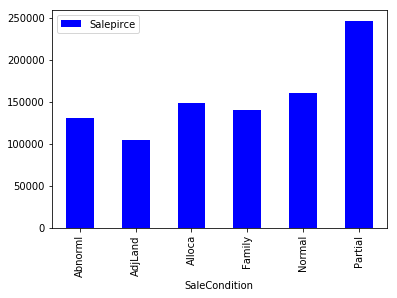

In [422]:
SaleCondition_table = train.groupby('SaleCondition').median().SalePrice.reset_index(name = 'Salepirce')
SaleCondition_table.plot(kind='bar', x='SaleCondition', y='Salepirce', color = 'blue');

Like I have used correlation to determine the correlation of numeric values with **SalePrice**, I will use ANOVA to determine the correlation between categorical values and **SalePrice**. 

In [ ]:
from scipy import stats

cat = [f for f in train.columns if train.dtypes[f] == 'object']
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cat_data['SalePrice'] = train.SalePrice.values
k =anova(cat_data)
k['disparity'] = np.log(1. / k['pval'].values)
plt.figure(figsize = [10,5])
sns.barplot(data=k, x='features', y='disparity')
plt.xticks(rotation=90);  

In the next I will check the distribution of all the numeric variables with histgram. 

In [ ]:
num = [f for f in train.columns if train.dtypes[f] != 'object']
num.remove('Id')

nd = pd.melt(train, value_vars= num)
n1 = sns.FacetGrid(nd, col='variable', col_wrap=4, sharex=False, sharey=False)
n1.map(sns.distplot, 'value');

In [ ]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

cat = [f for f in train.columns if train.dtypes[f] == 'object']

nd = pd.melt(train, value_vars= cat, id_vars='SalePrice')
nl = sns.FacetGrid(nd, col='variable', col_wrap=3, sharex=False, sharey=False)
nl.map(boxplot, 'value', 'SalePrice');

## Data Preprocessing

 I have found that the feature **GriLivArea** contains four outliers. Those rows (4 rows) are removed.

In [330]:
to_drop = train[train['GrLivArea'] > 4000]
train.drop(to_drop.index, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
def factorize(data, var, fill_na = None):
    if fill_na is not None:
        data[var].fillna(fill_na, inplace=True)
    le.fit(data[var])
    data[var] = le.transform(data[var])
    return data

In [ ]:
for i in train.columns:
    if train[i].isnull().any():
        print (i)

In [374]:
combined = train.append(test)
combined.shape

(2915, 81)

First I will group **LotFrontage** by **Neighbourhodd** and fill the missing value of **LotFrontage** with the median of the according **Neighbourhodd** . 

In [375]:
lot_frontage_by_neighborhood = train['LotFrontage'].groupby(train['Neighborhood'])

for key, group in lot_frontage_by_neighborhood:
    idx = (combined['Neighborhood'] == key) & (combined['LotFrontage'].isnull())
    combined.loc[idx, 'LotFrontage'] = group.median()

For the rest of the numeric features, the null value will be filled with 0.

In [376]:
to_fill_num = []
for i in combined.columns:
    if combined[i].dtypes != 'object':
        if combined[i].isnull().any():
            to_fill_num.append(i)

to_fill_num.remove('SalePrice')

for col in to_fill_num:
    combined[col].fillna(0, inplace=True)

Next I will deal with categorical features. The categorical data that are ordinal are transformed to numeric values in the scale of to up to 8. 0 indicates missing values and larger numbers indicate higher quality of the feature. 

In [377]:
to_fill_cat = []
for i in combined.columns:
    if combined[i].dtypes == 'object':
        if combined[i].isnull().any():
            to_fill_cat.append(i)

to_fill_cat

['Alley',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'Electrical',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'KitchenQual',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'PoolQC',
 'SaleType',
 'Utilities']

In [378]:
qual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0}
name = ['ExterQual', 'ExterCond','BsmtCond','BsmtQual','FireplaceQu',\
        'GarageCond','GarageQual','KitchenQual','PoolQC', 'HeatingQC']

for i in name:
    combined[i] = combined[i].map(qual_dict).astype(int)

In [379]:
combined['BsmtExposure'] = combined['BsmtExposure'].map({'Gd':4, 'Av':3, 'Mn':2,'No':1, np.nan:0}).astype(int)

In [380]:
BsmtFinType_map = {'Unf':1, 'GLQ':6, 'ALQ':5, 'Rec':3, 'BLQ':4,'LwQ':2, np.nan:0}
combined['BsmtFinType1'] = combined['BsmtFinType1'].map(BsmtFinType_map).astype(int)
combined['BsmtFinType2'] = combined['BsmtFinType2'].map(BsmtFinType_map).astype(int)

In [381]:
Functional_map = {'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1, np.nan:0}
combined['Functional'] = combined['Functional'].map(Functional_map).astype(int)

In [382]:
GarageFinish_map = {np.nan:0, 'Unf':1, 'RFn':2, 'Fin':3}
combined['GarageFinish'] = combined['GarageFinish'].map(GarageFinish_map).astype(int)

In [383]:
Fence_map = {'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1, np.nan:0}
combined['Fence'] = combined['Fence'].map(Fence_map).astype(int)

In [384]:
combined.CentralAir = (combined.CentralAir == 'Y')*1.0

In the next section, the categorical variable that are not ordinal are encodes with the sklearn LabelEncoder.  

In [385]:
varst = ['BldgType','Condition1','Foundation','HouseStyle','LotConfig','Neighborhood','RoofStyle','SaleCondition']
for x in varst:
    factorize(combined, x)

Last I will deal with the categorical variables that have missing values. I will fill in the missing values with either the mode or 'Other'. 

In [386]:
factorize(combined, 'Exterior1st', 'Other')
factorize(combined, 'Exterior2nd', 'Other')
factorize(combined, 'MSZoning', 'RL')
factorize(combined, 'MasVnrType', 'None')
factorize(combined, 'SaleType', 'Oth')

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,Id,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,0,3,1,706.0,0.0,6,1,1.0,0.0,4,150.0,1.0,2,Norm,SBrkr,0,3,4,13,13,0,0,0,2,2,8,548.0,2.0,3,2,3,Attchd,2003.0,1710,1,GasA,5,5,1,1,4,Lvl,Gtl,8450,4,65.0,Reg,0,60,3,196.0,1,NaN,0,2,5,61,5,7,Y,0,0,CompShg,1,4,208500.0,8,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,0,3,4,978.0,0.0,5,1,0.0,1.0,4,284.0,1.0,1,Norm,SBrkr,0,3,3,8,8,0,3,1,1,2,8,460.0,2.0,3,2,3,Attchd,1976.0,1262,0,GasA,5,2,2,1,3,Lvl,Gtl,9600,2,80.0,Reg,0,20,3,0.0,2,NaN,0,5,24,0,8,6,Y,0,0,CompShg,1,4,181500.0,8,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,0,3,2,486.0,0.0,6,1,1.0,0.0,4,434.0,1.0,2,Norm,SBrkr,0,3,4,13,13,0,3,1,2,2,8,608.0,2.0,3,2,3,Attchd,2001.0,1786,1,GasA,5,5,3,1,4,Lvl,Gtl,11250,4,68.0,IR1,0,60,3,162.0,1,NaN,0,9,5,42,5,7,Y,0,0,CompShg,1,4,223500.0,8,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,0,4,1,216.0,0.0,5,1,1.0,0.0,3,540.0,1.0,2,Norm,SBrkr,272,3,3,14,15,0,4,1,0,1,8,642.0,3.0,3,1,3,Detchd,1998.0,1717,0,GasA,4,5,4,1,4,Lvl,Gtl,9550,0,60.0,IR1,0,70,3,0.0,2,NaN,0,2,6,35,5,7,Y,0,0,CompShg,1,0,140000.0,8,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,0,3,3,655.0,0.0,6,1,1.0,0.0,4,490.0,1.0,2,Norm,SBrkr,0,3,4,13,13,0,3,1,2,2,8,836.0,3.0,3,2,3,Attchd,2000.0,2198,1,GasA,5,5,5,1,4,Lvl,Gtl,14260,2,84.0,IR1,0,60,3,350.0,1,NaN,0,12,15,84,5,8,Y,0,0,CompShg,1,4,250000.0,8,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
5,796,566,320,NaN,1,0,3,1,732.0,0.0,6,1,1.0,0.0,4,64.0,1.0,2,Norm,SBrkr,0,3,3,13,13,3,0,0,5,1,8,480.0,2.0,3,1,3,Attchd,1993.0,1362,1,GasA,5,0,6,1,3,Lvl,Gtl,14115,4,85.0,IR1,0,50,3,0.0,2,Shed,700,10,11,30,5,5,Y,0,0,CompShg,1,4,143000.0,8,0,Pave,5,796.0,AllPub,40,1993,1995,2009
6,1694,0,0,NaN,3,0,3,3,1369.0,0.0,6,1,1.0,0.0,5,317.0,1.0,2,Norm,SBrkr,0,3,4,13,13,0,4,1,2,2,8,636.0,2.0,3,2,3,Attchd,2004.0,1694,0,GasA,5,2,7,1,4,Lvl,Gtl,10084,4,75.0,Reg,0,20,3,186.0,3,NaN,0,8,21,57,5,8,Y,0,0,CompShg,1,4,307000.0,8,0,Pave,7,1686.0,AllPub,255,2004,2005,2007
7,1107,983,0,NaN,3,0,3,2,859.0,32.0,5,4,1.0,0.0,4,216.0,1.0,4,Norm,SBrkr,228,3,3,6,6,0,3,2,1,2,8,484.0,2.0,3,2,3,Attchd,1973.0,2090,1,GasA,5,5,8,1,3,Lvl,Gtl,10382,0,80.0,IR1,0,60,3,240.0,3,Shed,350,11,14,204,6,7,Y,0,0,CompShg,1,4,200000.0,8,0,Pave,7,1107.0,AllPub,235,1973,1973,2009
8,1022,752,0,NaN,2,0,3,1,0.0,0.0,1,1,0.0,0.0,3,952.0,1.0,0,Norm,FuseF,205,3,3,3,15,0,3,2,0,2,7,468.0,2.0,3,1,2,Detchd,1931.0,1774,0,GasA,4,0,9,2,3,Lvl,Gtl,6120,4,51.0,Reg,0,50,4,0.0,2,NaN,0,4,17,0,5,7,Y,0,0,CompShg,1,0,129900.0,8,0,Pave,8,952.0,AllPub,90,1931,1950,2008
9,1077,0,0,NaN,2,1,3,1,851.0,0.0,6,1,1.0,0.0,3,140.0,1.0,0,Artery,SBrkr,0,3,3,8,8,0,3,2,0,1,8,205.0,1.0,3,2,4,Attchd,1939.0,1077,0,GasA,5,1,10,2,3,Lvl,Gtl,7420,0,50.0,Reg,0,190,3,0.0,2,NaN,0,1,3,4,6,5,Y,0,0,CompShg,1,4,118000.0,8,0,Pave,5,991.0,AllPub,0,1939,1950,2008


## Feature Engineering

In [366]:
combined.shape

(2915, 81)

In [387]:
combined['IsRegularLotShape'] = (combined['LotShape'] == 'Reg') * 1
combined['IsLandLevel'] = (combined['LandContour'] == 'Lv1') * 1
combined['IsLandSlopeGentle'] = (combined['LandSlope'] == 'Gt1') * 1
combined['IsElectricalSbrkr'] = (combined['Electrical'] == 'SBrkr') * 1
combined['IsGarageDetached'] = (combined['GarageType'] == 'Detchd') * 1
combined['IsPavedDrive'] = (combined['PavedDrive'] == 'Y') * 1
combined['HasShed'] = (combined['MiscFeature'] == 'Shed') * 1
combined['Remodeled'] = (combined['YearRemodAdd'] != combined['YearBuilt']) * 1

In [388]:
#RecentRemodel indicates the the remodeling happened in the same year as the house sold
combined['RecentRemodel'] = (combined['YearRemodAdd'] == combined['YrSold']) * 1

In [389]:
#Was this house sold in the same year it was built
combined['VeryNewHouse'] = (combined['YearBuilt'] == combined['YrSold']) * 1

In [418]:
combined['Has2ndFloor'] = (combined['2ndFlrSF'] == 0)*1
combined['HasMasVnr'] = (combined['MasVnrArea'] == 0)*1
combined['HasWoodDeck'] = (combined['WoodDeckSF'] == 0)*1
combined['HasOpenPorch'] = (combined['OpenPorchSF'] == 0)*1
combined['HasEnclosedPorch'] = (combined['EnclosedPorch'] == 0)*1
combined['Has3snPorch'] = (combined['3SsnPorch'] == 0)*1
combined['HasScreenPorch'] = (combined['ScreenPorch'] == 0)*1

In [401]:
#Set levels with high count as 1 and rest as 0
combined['HighSeason'] = combined['MoSold'].map({1:0, 2:0, 3:0,4:1,5:1,6:1,7:1,8:0,9:0,10:0,11:0,12:0})

In [409]:
#Set levels with high count as 1 and rest as 0
combined['NewerDwelling'] = combined['MSSubClass'].map({60:1,  20:1,  70:0,  50:1, 190:0,  45:0,  90:0, 120:1, 30:0, 85:0, 80:0, 160:0, 75:0,
       180:0, 40:0, 150:0})

In [421]:
combined.shape

(2915, 100)